# Accreting Objects Database - Updating Distances

This notebook is used to query the Simbad and VizieR databases to obtain parallax angles for the objects in the Accreting Objects Database. It does this using names from the current version of the "master sheet" in the "Accretion Rate Database Edited" shared file. 

## Data Setup

In [1]:
#Imports all necessary packages for arithmetic, data manipulation, display, and querying.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import scipy.stats as st
from astroquery.simbad import Simbad
from subprocess import *

The printout above about "gzip" doesn't seem to have any bearing on the fuctionality of astroquery, so you can safely ignore it.

In [2]:
#Makes relevant table information easier to see
pd.options.display.max_columns=None
pd.options.display.max_rows=50

### Master Google Sheet

In [3]:
#Reads downloaded .csv file from Master AccDB sheet and displays it
accdb = pd.read_csv('accdb_master.csv')
accdb

,Simbad-Resolvable Name,Source,Alternative Names,Star Forming Region,COORDS,Disk Type,Reference,Epoch,Effective Temperature K,Temp err,Sp Type,Sp Type Err,Method,Wavelength Range,Instrument,Tracer,Accretion Diagnostic,Line Flux erg/s/cm^2,Object Luminosity L_solar,Object Luminosity Error,Object Radius from L and T,R_err from L and T,Object Radius R_solar,R_err,Accretion Rate M_solar yr-1,Log Accretion Rate,Object Mass Range M_solar,Object Mass M_Solar,Object Mass Err,log object mass,Accretion Luminosity (CGS),Log Accretion Luminosity (solar),Age range Myr,System Age Myr,Companion?,A_V,A_V err,A_V source,Notes/Questions,Notes/Questions2,Notes/Questions3,Unnamed: 41
0,2MASS J16085953-3856275,2MASS J16085953-3856275,NaN,Lupus,242.24804167 -38.94097222,II,Alcala 2017,NaN,2600.0,NaN,M8.5,0.5,medium resolution spectra,310-2500 nm,VLT X-shooter,Line Strength,Hydrogen lines Helium lines Calcium lines Sodi...,NaN,NaN,NaN,NaN,NaN,0.47,0.11,2.510000e-11,-10.600000,NaN,0.020000,0.01,-1.70,NaN,-4.6,3-10,3.00,NaN,0.0,NaN,Nisini+2017,Barraffe 15,NaN,NaN,1.50E+02
1,2MASS J15414081-3345188,2MASS J15414081-3345188,AKC2006-18,Lupus,235.42003733 -33.75523944,II,Alcala 2017,2015,2940.0,NaN,M6.5,0.5,medium resolution spectra,310-2500 nm,VLT X-shooter,Line Strength,Hydrogen lines Helium lines Calcium lines Sodi...,NaN,NaN,NaN,NaN,NaN,0.40,0.09,6.310000e-12,-11.200000,NaN,0.070000,0.01,-1.15,NaN,-4.6,3-10,3.00,NaN,0.0,NaN,Nisini+2017,Barraffe 15,NaN,NaN,NaN
2,2MASS J16083733-3923109,2MASS J16083733-3923109,Lup706,Lupus,242.15555937 -39.38636833,II,Alcala 2017,NaN,2800.0,NaN,M7.5,0.5,medium resolution spectra,310-2500 nm,VLT X-shooter,Line Strength,Hydrogen lines Helium lines Calcium lines Sodi...,NaN,NaN,NaN,NaN,NaN,0.22,0.05,2.510000e-12,-11.600000,NaN,0.050000,0.01,-1.30,NaN,-4.8,3-10,3.00,NaN,0.0,NaN,Nisini+2017,Barraffe 15,NaN,NaN,NaN
3,ISO-Oph 033,ISO-Oph 033,"ISO-Oph 033, GY 11",p Oph,246.592788 -24.401962,II,Comeron 2010,February 26 - March 30 2003,2700.0,100.0,M6.5,NaN,R 260 long slit spectroscopy,6000-10000 A,VLT/FORS1,line strength,Ca II,1.020000e+06,0.005,NaN,NaN,NaN,NaN,NaN,9.500000e-10,-9.022276,0.02-0.04,0.028629,NaN,NaN,NaN,NaN,NaN,1.00,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ISO-Oph 023,ISO-Oph 023,NaN,p Oph,246.578419 -24.436256,II,Gatti 2006,May 19 20 2005,2650.0,150.0,M7,2.0,".06"" spectra 750 - 860 R spectra",2 - 2.4 um,ISAAC/ESO-VLT UT1 telescope,Line Width,EW PaB & BrG,NaN,0.040,NaN,0.95,NaN,NaN,NaN,2.040000e-10,-9.690000,NaN,0.040000,NaN,NaN,NaN,NaN,.1-1,1.00,NaN,9.0,NaN,"Gatti+2018, converted from A_j",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,NaN,DH Tau b,NaN,Taurus,67.423583 26.549028,II,Zhou 2014,NaN,2350.0,150.0,NaN,NaN,optical broadband photometry,optical,NaN,Excess,Excess Balmer,8.360000e-18,NaN,NaN,NaN,NaN,NaN,NaN,3.162000e-12,NaN,NaN,0.010000,NaN,NaN,NaN,NaN,NaN,4.34,Companion,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524,NaN,DH Tau b,NaN,Taurus,67.423583 26.549028,II,Zhou 2014,NaN,2200.0,NaN,NaN,NaN,optical broadband photometry,optical,NaN,Excess,Excess Balmer,8.360000e-18,NaN,NaN,NaN,NaN,NaN,NaN,5.011000e-12,NaN,NaN,0.010000,NaN,NaN,NaN,NaN,NaN,4.34,Companion,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525,NaN,Lk Ca 15b,NaN,NaN,69.8250 22.35094,II,Sallum 2015,NaN,NaN,NaN,NaN,NaN,spectroscopy,300 nm to 2.2 μm,X-Shooter and VLT,Line Luminsoity,Ha Line Strength,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.725000e-10,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,2.00,Companion,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526,NaN,PDS 70 b,NaN,Centaurus,212.04231047 -41.39793796,II,Aoyama 2019,NaN,NaN,NaN,NaN,NaN,narrowed down from Haffert and Wagner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.817000e-11,NaN,NaN,0.010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Fixing some designations to make them more Simbad/VizieR-friendly:

In [4]:
#Creates an empty list
names = []
#Iterates through all the names in the master sheet
for i in range(len(accdb["Simbad-Resolvable Name"])):
    #Creates container value for the next name
    nextname = accdb["Simbad-Resolvable Name"][i]
    #Points out problematic data types; at last check, these were just "nans" in the rows connected to PDS 70's planets,
    #and constitute an easy fix in a text file.
    if type(nextname)!=str:
        print("Element "+str(i)+", "+str(nextname)+", is not a string!")
    #Otherwise, takes action against known issues before adding
    else:
        #Finds objects whose names start with "NAME ", an artifact of the way non-resolvable names were corrected
        if nextname[0]=='N' and nextname[1]=='A' and nextname[2]=='M' and nextname[3]=='E' and nextname[4]==' ':
            newname=""
            #Jumps past this atifact to the designation itself and copies it into the new string
            j=5
            while j<len(nextname):
                newname+=nextname[j]
                j+=1
            #Replaces old string with new one
            nextname=newname
            print("Got rid of 'NAME ' artifact for "+nextname+"!")
        #Finds objects with Schwartz 1977 designations, which have caused problems with Simbad when there is no space between
        #the "Sz" and the object's number
        if nextname[0]=='S' and nextname[1]=='z':
            #Creates empty string with a space after "Sz"
            newname = "Sz "
            #Numbers in original string should start after index [2], creates tracker to iterate through these
            j=2
            #Concatenate characters from old string to new one until the end is reached
            while j<len(nextname):
                newname+=nextname[j]
                j+=1
            #Replaces old string
            nextname=newname
        #Finds multi-object system component designations which (a) are unlikey to have their own entries in the database and (b) likely possess
        #the same distance and parallax as their host, meaning we can just get rid of all but one.
        if nextname[-1]=="A" or nextname[-1]=="a" or nextname[-1]=="B" or nextname[-1]=="b" or nextname[-1]=="C" or \
        nextname[-1]=="c" or nextname[-1]=="D" or nextname[-1]=="d":
            #Prints the name we started with
            print("Before: "+nextname)
            newname=""
            #Checks to make sure that, if an "a" is detected, it is not at the end of the association designations like
            #"Cha" or "Hya"
            if nextname[-2] != "h" and nextname[-2] != "y":
                #Iterates through old name to copy over to new name, stopping before it reaches the last problematic character
                for k in range(len(nextname)-1):
                    newname+=nextname[k]
                #Replaces old string
                nextname=newname
                #Prints what the new name is, if it changed it
                print("After: "+nextname)
        #If the name is a string, has all necessary changes made, and is not a duplicate, add it to list. Assumes that
        #duplicates are adjacent in table, which has proven to be generally true
        if i==0 or nextname != names[-1]:
            names.append(nextname)
        else:
            print("Eliminated duplicate: "+nextname)

print()

#Display the new names
for i in range(len(names)):
    print(names[i])
print();print("Length: "+str(len(names)))

Eliminated duplicate: 2MASS J12073346-3932539
Eliminated duplicate: 2MASS J12073346-3932539
Before: Oph 11A
After: Oph 11
Before: Oph 11B
After: Oph 11
Eliminated duplicate: Oph 11
Eliminated duplicate: 2MASS J12073346-3932539
Eliminated duplicate: 2MASS J04394748+2601407
Eliminated duplicate: 2MASS J16273863-2438391
Eliminated duplicate: Cl* IC 348 LRL 291
Eliminated duplicate: Cl* IC 348 LRL 415
Eliminated duplicate: 2MASS J04190126+2802487
Eliminated duplicate: 2MASS J04272799+2612052
Eliminated duplicate: 2MASS J04300724+2608207
Eliminated duplicate: 2MASS J04305718+2556394
Eliminated duplicate: DENIS J160603.9-205644
Eliminated duplicate: [NC98] Cha HA 1
Eliminated duplicate: [NC98] Cha HA 2
Eliminated duplicate: [NC98] Cha HA 3
Eliminated duplicate: [NC98] Cha HA 6
Eliminated duplicate: 2MASS J16262152-2426009
Eliminated duplicate: 2MASS J16270659-2441488
Element 104, nan, is not a string!
Element 105, nan, is not a string!
Element 106, nan, is not a string!
Element 107, nan, is 

At this point, I usually copy this printout and paste it into a .txt file. This is to (1) fix some things that are easier to correct in even a limited word processor, and (2) to upload into VizieR for a list query. The next cell reads this file back into a list, since we might as well use it while we have it. However, since writing that cell, I have improved the duplicate elimination in this cell, which has absolved any discernable need to use the text editor. I will keep this setup in case that stops being true in the future, though. Note: the Python ".readlines()" function of the next cell skips the very last character in the file, so add an additional character like a space at the very end to preserve the last item.

In [5]:
#Opens the .txt file in this directory in a read ("r") capacity
targetlist = open("Target list.txt", "r")
#Generates a list of strings from all of the lines in the text file
lines=targetlist.readlines()

#.txt files return their strings with the newline character "\n" included-- we need to get rid of them.

#Creates an empty list
newnames=[]
#Iterates through every element in "lines"
for i in range(len(lines)):
    #Adds an empty string to "newnames"
    newnames.append("")
    #Iterates through every character in the read names except for the last one, which should be "\n"
    for j in range(len(lines[i])-1):
        #Copies the contents of the old string into the new
        newnames[i]+=lines[i][j]
#Closes the file
targetlist.close()
#Prints our new list
newnames

['2MASS J16085953-3856275',
 '2MASS J15414081-3345188',
 '2MASS J16083733-3923109',
 'ISO-Oph 033',
 'ISO-Oph 023',
 '2MASS J16262152-2426009',
 'ISO-Oph 033',
 '2MASS J16270659-2441488',
 'ISO-Oph 160',
 '2MASS J16273863-2438391',
 '2MASS J16281271-2411355',
 '2MASS J04141188+2811535',
 '2MASS J04390396+2544264',
 '2MASS J04414825+2534304',
 '2MASS J04442713+2512164',
 '2MASS J12073346-3932539',
 'DENIS J160603.9-205644',
 'Oph 11',
 '2MASS J11020983-3430355',
 '2MASS J16060374-2219298',
 '2MASS J16072382-2211018',
 '2MASS J15591135-2338002',
 'ISO-Oph 023',
 'ISO-Oph 032',
 'ISO-Oph 033',
 'ISO-Oph 160',
 '2MASS J16273863-2438391',
 '2MASS J16274629-2431411',
 '2MASS J12073346-3932539',
 '2MASS J04394748+2601407',
 '2MASS J16273863-2438391',
 'Cl* IC 348 LRL 291',
 'Cl* IC 348 LRL 415',
 '2MASS J04190126+2802487',
 '2MASS J04272799+2612052',
 '2MASS J04300724+2608207',
 '2MASS J04305718+2556394',
 'DENIS J160603.9-205644',
 'Cl* IC 348 LRL 382',
 'Cl* IC 348 LRL 415',
 '2MASS J043216

### Simbad

In [4]:
#Instantiates a Simbad query object-- variable name chosen here is arbitrary
querybase = Simbad()
#Adds fields pertaining to parallax angle and distance to query so that they will appear in the resulting table
querybase.add_votable_fields('distance')
querybase.add_votable_fields('parallax')

In [7]:
#Queries Simbad using our refined name list and converts it to a Pandas DataFrame
accdists = querybase.query_objects(newnames).to_pandas()
#Iterates through every row in table
for i in range(len(accdists["MAIN_ID"])):
    #Decodes some problematic string columns from "byte" type to UTF-8 string type
    accdists.loc[i, "MAIN_ID"] = accdists.loc[i, "MAIN_ID"].decode("utf-8")
    accdists.loc[i, "PLX_BIBCODE"] = accdists.loc[i, "PLX_BIBCODE"].decode("utf-8")
    accdists.loc[i, "COO_BIBCODE"] = accdists.loc[i, "COO_BIBCODE"].decode("utf-8")
#Prints the results
accdists

C:\Users\pauld\Anaconda3\lib\site-packages\astroquery\simbad\core.py:138: UserWarning: Warning: The script line number 305 raised an error (recorded in the `errors` attribute of the result table): 'Par-Lup3-3' this identifier has an incorrect format for catalog: 	Par (Parenago): Parenago  
  (error.line, error.msg))


,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,PLX_BIBCODE
0,2MASS J16085953-3856275,16 08 59.5393,-38 56 27.596,14,14,0.2324,0.0891,90,A,O,2018yCat.1345....0G,150.2291,,pc,-6.3102,6.3102,paral,2018yCat.1345....0G,6.6565,4,0.2796,A,2018yCat.1345....0G
1,2MASS J15414081-3345188,15 41 40.8089,-33 45 18.862,14,14,0.2795,0.1973,90,A,O,2018yCat.1345....0G,149.3340,,pc,-7.7740,7.7740,paral,2018yCat.1345....0G,6.6964,4,0.3486,A,2018yCat.1345....0G
2,2MASS J16083733-3923109,16 08 37.3342,-39 23 10.926,14,14,0.7415,0.2288,90,A,O,2018yCat.1345....0G,NaN,,,NaN,NaN,,,5.3478,4,0.8740,A,2018yCat.1345....0G
3,[RR90] Oph 2320.8-1721,16 26 22.2691,-24 24 07.063,9,9,100.0000,90.0000,90,C,N,2003yCat.2246....0C,NaN,,,NaN,NaN,,,NaN,0,NaN,,
4,CRBR 2317.3-1925,16 26 18.8205,-24 26 10.521,9,9,80.0000,70.0000,90,C,N,2003yCat.2246....0C,NaN,,,NaN,NaN,,,NaN,0,NaN,,
5,[GY92] 5,16 26 21.5389,-24 26 01.000,14,14,0.1652,0.0786,90,A,O,2018yCat.1345....0G,136.5930,,pc,-3.6233,3.6233,paral,2018yCat.1345....0G,7.3210,4,0.1942,A,2018yCat.1345....0G
6,[RR90] Oph 2320.8-1721,16 26 22.2691,-24 24 07.063,9,9,100.0000,90.0000,90,C,N,2003yCat.2246....0C,NaN,,,NaN,NaN,,,NaN,0,NaN,,
7,[GY92] 204,16 27 06.5924,-24 41 48.883,14,14,0.1260,0.0631,90,A,O,2018yCat.1345....0G,142.1220,,pc,-2.6803,2.6803,paral,2018yCat.1345....0G,7.0362,4,0.1327,A,2018yCat.1345....0G
8,BKLT J162737-241756,16 27 37.4272,-24 17 54.955,14,14,0.8118,0.4522,90,A,O,2018yCat.1345....0G,NaN,,,NaN,NaN,,,7.0079,4,0.9044,A,2018yCat.1345....0G
9,[GY92] 310,16 27 38.6280,-24 38 39.230,14,14,0.4583,0.2457,90,A,O,2018yCat.1345....0G,142.6640,,pc,-10.1703,10.1703,paral,2018yCat.1345....0G,7.0095,4,0.4997,A,2018yCat.1345....0G


In [8]:
#Creates counter for objects with parallaxes
yesplx=0
#Creates counter for objects with non-Gaia parallaxes
plx_notdrtwo=0
#Creates counter for objects without distances
yesdist=0
#Creates counter for distances without references
dist_noref=0
#Creates counter for objects that have distances but not parallax angles
distnoplx=0
#Iterates through every parallax value in Simbad return table
for i in range(len(accdists["PLX_VALUE"])):
    #If a parallax is recorded, increment respective counter
    if not np.isnan(accdists["PLX_VALUE"][i]):
        yesplx+=1
    #If distance is recorded but parallax is not, increment respective counter
    elif not np.isnan(accdists["Distance_distance"][i]):
        distnoplx+=1
    #If a parallax reference is provided that is not Gaia DR2, increment respective counter
    if accdists["PLX_BIBCODE"][i]!="" and accdists["PLX_BIBCODE"][i]!="2018yCat.1345....0G":
        plx_notdrtwo+=1
    #If a distance is provided...
    if not np.isnan(accdists["Distance_distance"][i]):
        #...increment respective counter
        yesdist+=1
        #If a distance is provided without a reference, increment respective counter
        if accdists["Distance_bibcode"][i]=='':
            dist_noref+=1
        #If a distance is provided with a reference other than Gaia DR2, give its name, its distance and parallax references,
        #and the distance values obtained from each
        elif accdists["Distance_bibcode"][i]!='2018yCat.1345....0G' and accdists["Distance_bibcode"][i]!="2018A&A...616A...1G":
            print("Non-Gaia reference found: " + accdists["MAIN_ID"][i])
            print("     Distance bibcode: " + accdists["Distance_bibcode"][i] +
                  " ||| Parallax bibcode: " + accdists["PLX_BIBCODE"][i])
            print("     Reference distance: " + str(accdists["Distance_distance"][i]) +
                  " ||| Parallax distance: " + str(1000/accdists["PLX_VALUE"][i]))
            print()
#Prints counters
print("Objects with parallaxes: "+str(yesplx)+"/"+str(len(accdists["PLX_VALUE"]))+", or "
      +str(round(100*(yesplx/len(accdists["PLX_VALUE"])),2))+"%")
print("Objects with non-Gaia parallaxes: "+str(plx_notdrtwo))
print("Objects with distances: "+str(yesdist)+"/"+str(len(accdists["Distance_distance"]))+", or "
      +str(round(100*(yesdist/len(accdists["Distance_distance"])),2))+"%")
print("Distances without references: " + str(dist_noref))
print("Distances without recorded parallax: "+str(distnoplx))

Non-Gaia reference found: TWA 3
     Distance bibcode: 2006AJ....132..866R ||| Parallax bibcode: 
     Reference distance: 5.0 ||| Parallax distance: nan

Objects with parallaxes: 304/436, or 69.72%
Objects with non-Gaia parallaxes: 0
Objects with distances: 263/436, or 60.32%
Distances without references: 0
Distances without recorded parallax: 1


### VizieR

In [9]:
#Reads the VizieR Gaia data from the .tsv file included in this directory
gaiadata = pd.read_csv("gaiadata.tsv", delimiter="\t", skiprows=69)
#Drops the first two rows from this data, then adjusts indexing back to normal
gaiadata = gaiadata.drop(range(0,2)); gaiadata = gaiadata.reset_index(drop=True)
#Creates a list of column names containing numerical data
numcolumns=["RA_ICRS", "e_RA_ICRS", "DE_ICRS", "e_DE_ICRS", "Plx", "e_Plx", "pmRA", "e_pmRA", "pmDE", "e_pmDE",
            "RV", "e_RV", "Teff", "AG", "E(BP-RP)", "Rad", "Lum"]
#Iterates through column name list
for i in range(len(numcolumns)):
    #Converts the contents of each of these columns to numbers rather than number-charactered strings
    gaiadata[numcolumns[i]] = pd.to_numeric(gaiadata[numcolumns[i]], errors="coerce")
#Renames the columns to be more user-friendly
gaiadata.columns=["Simbad Name", "Right Ascension", "Right Ascension Error", "Declination", "Declination Error",
                 "Parallax Angle", "Parallax Angle Error", "RA Proper Motion", "RA Proper Motion Error", "Dec. Proper Motion",
                 "Dec. Proper Motion Error", "Duplicate? (0=n,1=y)", "Radial Velocity", "Radial Velocity Error",
                  "Effective Temperature", "G-band Extinction", "Reddening", "Radius", "Luminosity"]

#For some reason, Gaia returns the names with a long series of spaces after them-- this was causing problems matching
#the objects to their counterparts in the master table, so I created a function to fix them.

#Iterates through every object's name
for i in range(len(gaiadata["Simbad Name"])):
    #Assigns the starter name to a variable
    des=gaiadata["Simbad Name"][i]
    #Initializes the new name as an empty string
    newdes=""
    #Creates a variable to track how far from the end of the name the last non-space character is; starts at "-1,"
    #or the last character
    backdex=-1
    #While the character at this index is a space, keep moving this index back
    while des[backdex]==" ":
        backdex-=1
    #Calculates the true, 0-indexed position of the last non-space character
    index=len(des)+backdex
    #Copies the old string into the new one, stopping when it reaches the long stretch of spaces
    j=0
    while j<=index:
        newdes+=des[j]
        j+=1
    #Sets the value in the table to this new name. Not sure why it has to be done with this syntax, but otherwise
    #it somehow adds a number of columns to the table equal to the number of rows in the original table, and fills
    #them with NaNs. So please leave this be!
    gaiadata.loc[i,"Simbad Name"]=newdes

#Creates a new "Distance" column calculated from the parallax angles earlier in the table
gaiadata["Distance"]=1000/gaiadata["Parallax Angle"]
#Displays the table
gaiadata

,Simbad Name,Right Ascension,Right Ascension Error,Declination,Declination Error,Parallax Angle,Parallax Angle Error,RA Proper Motion,RA Proper Motion Error,Dec. Proper Motion,Dec. Proper Motion Error,"Duplicate? (0=n,1=y)",Radial Velocity,Radial Velocity Error,Effective Temperature,G-band Extinction,Reddening,Radius,Luminosity,Distance
0,2MASS J16085953-3856275,242.248026,0.2324,-38.941100,0.0891,6.6565,0.2796,-9.872,0.465,-23.526,0.300,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.229099
1,2MASS J15414081-3345188,235.419938,0.2795,-33.755330,0.1973,6.6964,0.3486,-19.095,0.575,-21.107,0.405,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.333970
2,2MASS J16083733-3923109,242.155490,0.7415,-39.386472,0.2288,5.3478,0.8740,-12.460,1.798,-24.016,0.873,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.992782
3,2MASS J16262152-2426009,246.589703,0.1652,-24.433720,0.0786,7.3210,0.1942,-9.050,0.403,-25.287,0.250,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.593362
4,2MASS J16270659-2441488,246.777442,0.1260,-24.697020,0.0631,7.0362,0.1327,-5.694,0.291,-25.030,0.197,0,NaN,NaN,3295.25,NaN,NaN,NaN,NaN,142.122168
5,ISO-Oph 160,246.905925,0.8118,-24.298712,0.4522,7.0079,0.9044,-4.693,2.667,-26.314,1.903,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.696100
6,2MASS J16273863-2438391,246.910918,0.4583,-24.644337,0.2457,7.0095,0.4997,-6.904,1.086,-24.646,0.719,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.663528
7,2MASS J16281271-2411355,247.052987,0.4858,-24.193370,0.2721,6.5901,0.5742,-6.087,1.051,-26.409,0.760,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.742766
8,2MASS J04141188+2811535,63.549554,0.1560,28.198067,0.0671,7.6285,0.1661,9.077,0.421,-23.889,0.211,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.087370
9,2MASS J04390396+2544264,69.766535,0.1860,25.740561,0.1150,6.9450,0.2107,7.037,0.362,-20.606,0.249,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.988481


In [10]:
#Writes the contents of the adjusted table to a .csv file to be used in Excel/Google Sheets
gaiadata.to_csv("gaia_parallaxes")

In [11]:
#Creates counter for the objects with Gaia parallaxes
gaiaplx=0
#Creates counter for matching VizieR and Simbad names
namematch=0
#Creates counter for the number of objects with only Simbad parallaxes
simnogaia=0
#Iterates through object parallaxes
for i in range(len(gaiadata["Parallax Angle"])):
    #Adds to counter if no value is provided
    if not np.isnan(gaiadata["Parallax Angle"][i]):
        gaiaplx+=1
    for j in range(len(accdists["MAIN_ID"])):
        if gaiadata["Simbad Name"][i]==accdists["MAIN_ID"][j]:
            namematch+=1
            if not np.isnan(accdists["PLX_VALUE"][j]) and np.isnan(gaiadata["Parallax Angle"][i]):
                simnogaia+=1
#Prints results
print("Gaia object returns with parallaxes: "+str(gaiaplx)+"/"+str(len(gaiadata["Parallax Angle"]))+", or "
      +str(round(100*(gaiaplx/len(gaiadata["Parallax Angle"])),2))+"%")
print("Object with only Simbad parallaxes among those whose names match between tables: "+str(simnogaia)+"/"+str(namematch)+
     ", or "+str(round(100*(simnogaia/namematch),2))+"%")

Gaia object returns with parallaxes: 333/361, or 92.24%
Object with only Simbad parallaxes among those whose names match between tables: 0/158, or 0.0%


## Some Fun Visualizations

The cell below produces two lists of the same length that can be used for plotting.

In [12]:
#Creates two empty lists, one for master sheet luminosities and one for corresponding Gaia distances
luminosities=[]; distances=[];
#Iterates through all the object names in the Gaia returns
for i in range(len(gaiadata["Simbad Name"])):
    #Iterates through all the object names in the master table
    for j in range(len(accdb["Simbad-Resolvable Name"])):
        #Checks if the names are the same
        if gaiadata["Simbad Name"][i]==accdb["Simbad-Resolvable Name"][j]:
            #Additional check to make sure the object has a parallax and luminosity recorded
            if not np.isnan(gaiadata["Parallax Angle"][i]) and not np.isnan(accdb["Object Luminosity L_solar"][j]):
                #Converts parallax to distance and adds it to the distance list; simply adds luminosity to the list
                distances.append(1000/gaiadata["Parallax Angle"][i]); luminosities.append(accdb["Object Luminosity L_solar"][j])

The cell below does the same thing as the cell above, but solely within the Gaia return.

In [13]:
lumes_gaia=[]; dists_gaia=[];
for i in range(len(gaiadata["Parallax Angle"])):
        if not np.isnan(gaiadata["Parallax Angle"][i]) and not np.isnan(gaiadata["Luminosity"][i]):
                dists_gaia.append(1000/gaiadata["Parallax Angle"][i]); lumes_gaia.append(gaiadata["Luminosity"][i])

The cell below does something similar to above cells, but takes different luminosity estimates for the same objects and places them in corresponding lists.

In [14]:
masterlumes=[]; gaialumes=[];
for i in range(len(gaiadata["Simbad Name"])):
    for j in range(len(accdb["Simbad-Resolvable Name"])):
        if gaiadata["Simbad Name"][i]==accdb["Simbad-Resolvable Name"][j]:
            if not np.isnan(gaiadata["Luminosity"][i]) and not np.isnan(accdb["Object Luminosity L_solar"][j]):
                gaialumes.append(gaiadata["Luminosity"][i]); masterlumes.append(accdb["Object Luminosity L_solar"][j])

Text(0.5, 1.0, 'Calculated Luminosities against Gaia Parallax Distances')

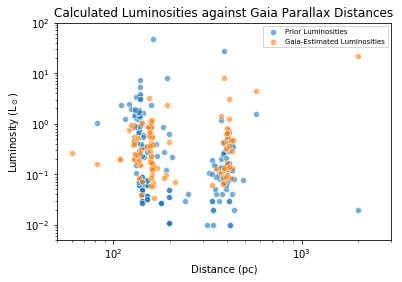

In [15]:
#Creates scatterplots of each dataset in different colors and with different labels
sbn.scatterplot(distances, luminosities, label="Prior Luminosities", alpha=0.6)
sbn.scatterplot(dists_gaia, lumes_gaia, label="Gaia-Estimated Luminosities", alpha=0.6)
#Labels, limits, and logarithmically scales both axes
plt.xscale("log")
plt.xlim(50,3000)
plt.xlabel("Distance (pc)")
plt.yscale("log")
plt.ylim(.005,100)
plt.ylabel("Luminosity (L$_\odot$)")
#Formats the title of the graph and the legend
plt.legend(fontsize=7)
plt.title("Calculated Luminosities against Gaia Parallax Distances")

Text(0.5, 1.0, 'Direct Comparison Between Luminosity Estimates')

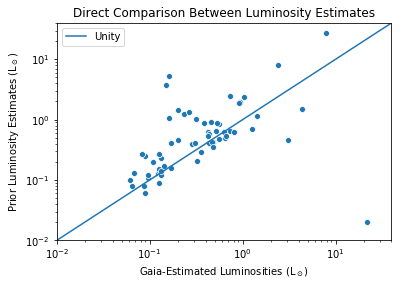

In [16]:
#Plots luminosity data
sbn.scatterplot(gaialumes, masterlumes)
#Creates line indicating where perfectly matching data would fall, with a slope of 1
plt.plot([0,50],[0,50], label="Unity")
#Labels, limits, and scales axes
plt.xlabel("Gaia-Estimated Luminosities (L$_\odot$)")
plt.xscale("log")
plt.xlim(.01,40)
plt.ylabel("Prior Luminosity Estimates (L$_\odot$)")
plt.yscale("log")
plt.ylim(.01,40)
#Labels overall plot
plt.legend()
plt.title("Direct Comparison Between Luminosity Estimates")